In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


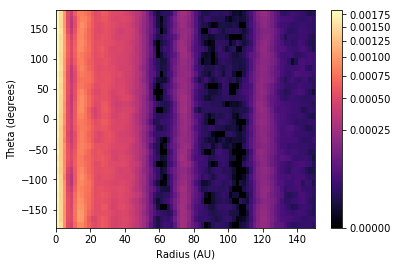

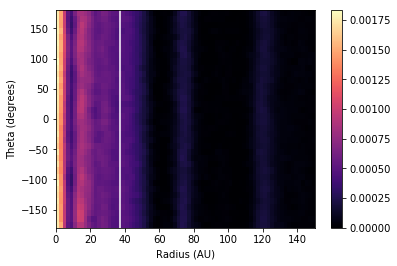

In [2]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/AS209tapered.image.fits',
                          'distance':121,
                          'incl' : 34.7,
                          'PA' : 86.2,
                          'offsetx' : 0.39*.003,
                          'offsety' : -1.12*.003,
                          'size': 3.5,
                          'gamma': 0.6
                         }

#make some preliminary plots
cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
    
radialbins = 1+2*np.arange(75)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0)
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.vlines(37,-180,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


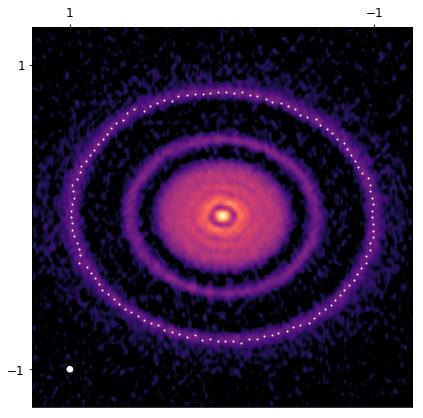

In [3]:
# Extract the ring that's at ~120 AU
xcoords1, ycoords1 = cont.extract_ring(110,130,tbins = -178.5+3*np.arange(120), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.5, 2.5)

In [4]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     1.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -1.706e-04 arcsec, delta_y = 1.751e-03 arcsec
The MLE semi-major axis is r = 0.994 arcsec
The MLE inclination is i = 34.926 degrees
The MLE position angle is PA = 85.666 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.518e+00


In [4]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    #flat priors on x0, y0, r0, logvar
    if not (-4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -15<logvar<-5):
        return -np.inf
    #gaussian prior on PA and cosi based on Fedele+ 2018
    sig_par = .0122
    sig_cosi = .008
    return -0.5*((par-1.50)/sig_par)**2-0.5*((cosi-0.816)/sig_cosi)**2

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 100
nthreads = 8
nsteps = 2000

In [40]:
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

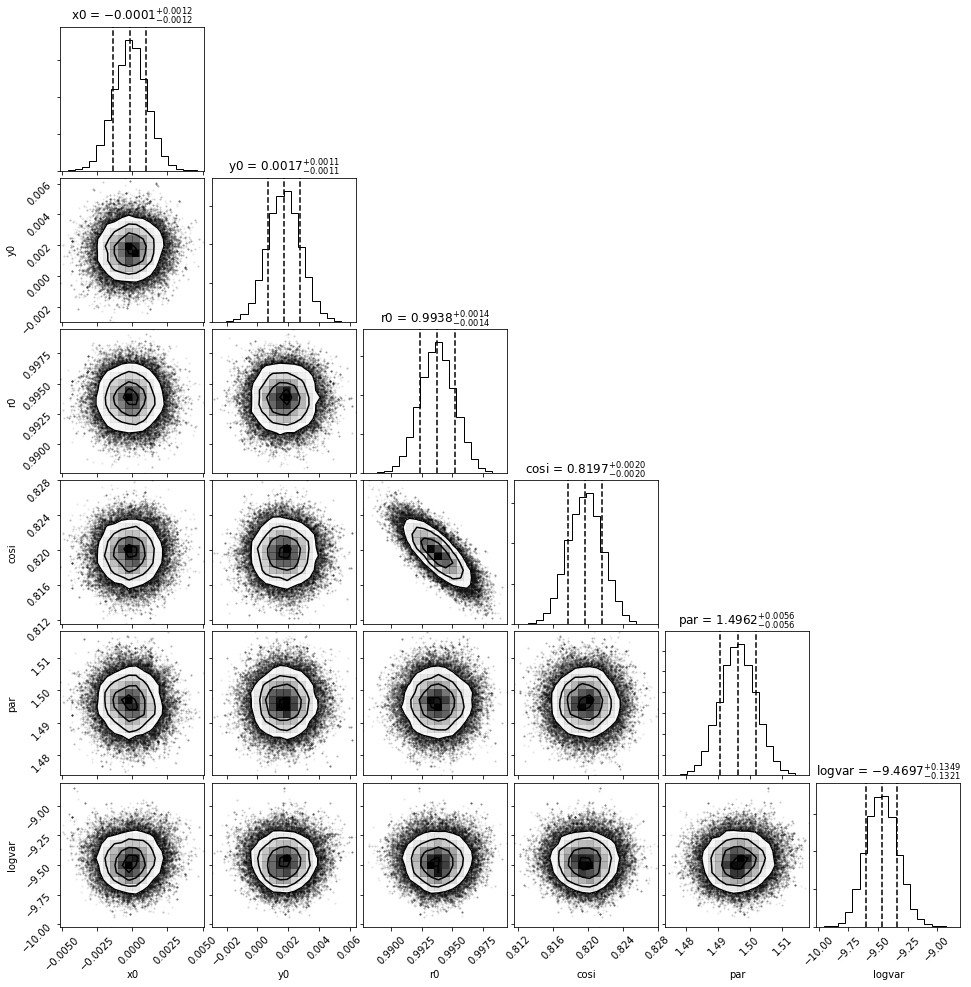

The x offset is delta_x = -1.49e-04 arcsec (+1.2e-03, -1.2e-03)
The y offset is delta_y = 1.73e-03 arcsec (+1.1e-03, -1.1e-03)
The median semi-major axis is r = 0.9938 arcsec (+0.0014, -0.0014) 
or 120.25 AU (+0.13, -0.13)
The incl is i = 34.95 deg (+0.20, -0.20)
The median position angle is PA = 85.73 deg (+0.32, -0.32)
The median log-variance in the pixel offsets from the true ellipse is -9.470e+00


In [42]:
plot_corner(sampler1, 1000, 1)
sampler_results(sampler1, 1000, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


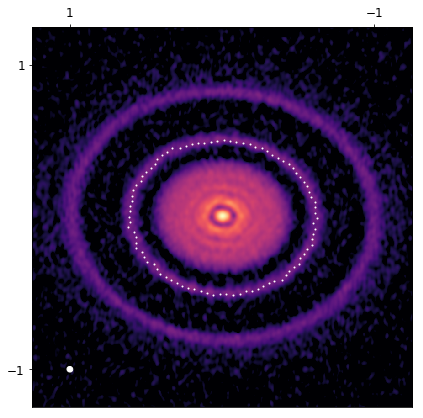

In [4]:
# Extract the ring that's at ~75 AU
xcoords2, ycoords2 = cont.extract_ring(65,85,tbins = -178+4*np.arange(90))

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.5, 2.5)

In [5]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     75/121.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -6.724e-04 arcsec, delta_y = -4.197e-03 arcsec
The MLE semi-major axis is r = 0.611 arcsec
The MLE inclination is i = 34.475 degrees
The MLE position angle is PA = 85.463 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.919e+00


In [6]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

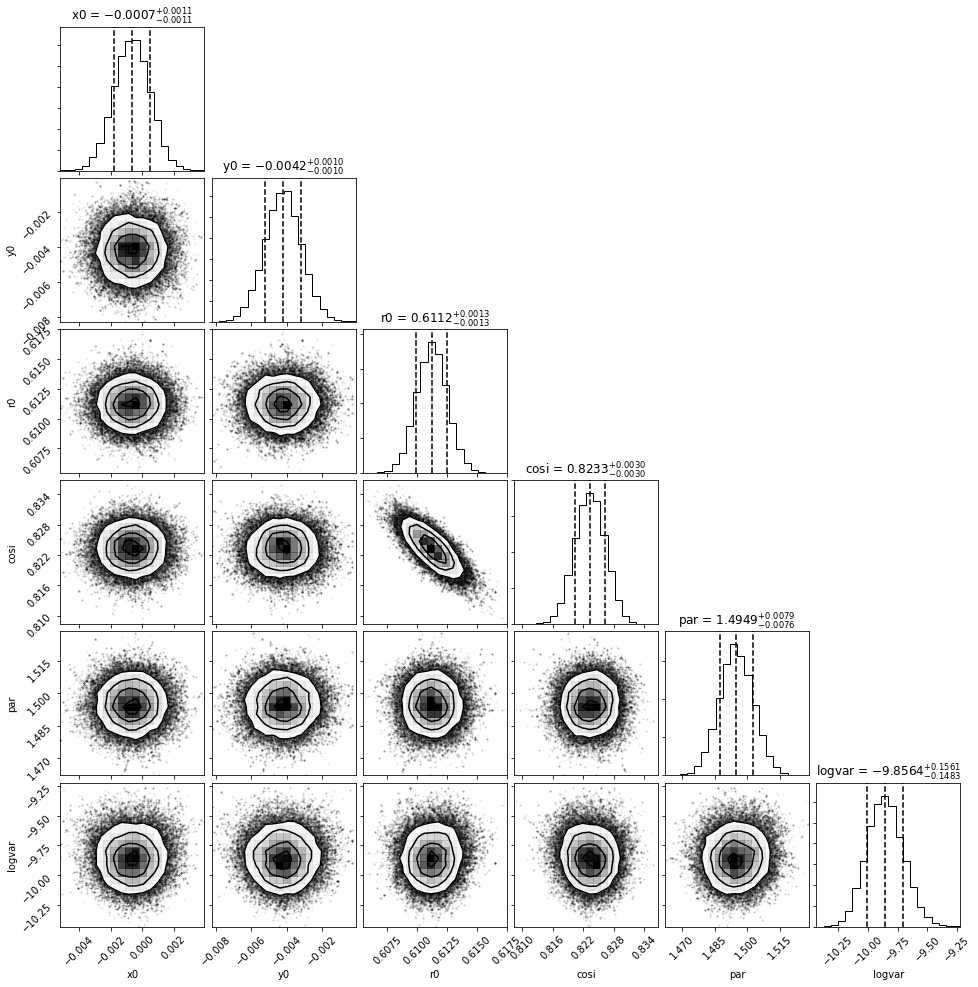

The x offset is delta_x = -6.61e-04 arcsec (+1.1e-03, -1.1e-03)
The y offset is delta_y = -4.20e-03 arcsec (+1.0e-03, -1.0e-03)
The median semi-major axis is r = 0.6112 arcsec (+0.0013, -0.0013) 
or 73.96 AU (+0.12, -0.13)
The incl is i = 34.58 deg (+0.30, -0.30)
The median position angle is PA = 85.65 deg (+0.45, -0.44)
The median log-variance in the pixel offsets from the true ellipse is -9.856e+00


In [7]:
plot_corner(sampler2, 1000, 1)
sampler_results(sampler2, 1000, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


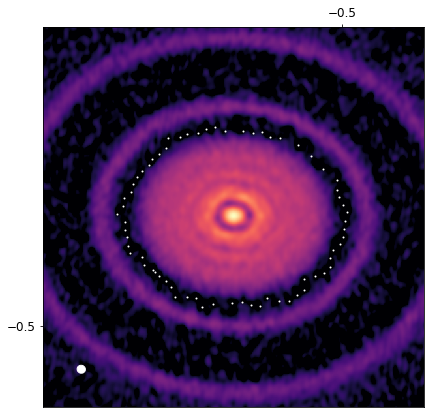

In [8]:
# Extract the gap that's at ~60 AU
xcoords3, ycoords3 = cont.extract_ring(55,65,tbins = -177.5+5*np.arange(72), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords3, ycoords3, 0.5, 1.75)

In [9]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_3 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     0.5,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords3, ycoords3)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -2.928e-03 arcsec, delta_y = -4.449e-03 arcsec
The MLE semi-major axis is r = 0.507 arcsec
The MLE inclination is i = 36.771 degrees
The MLE position angle is PA = 86.431 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.631e+00


In [10]:
sampler3 = run_mcmc(nwalkers, nthreads, nsteps, mle_3, lnprob, xcoords3, ycoords3)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

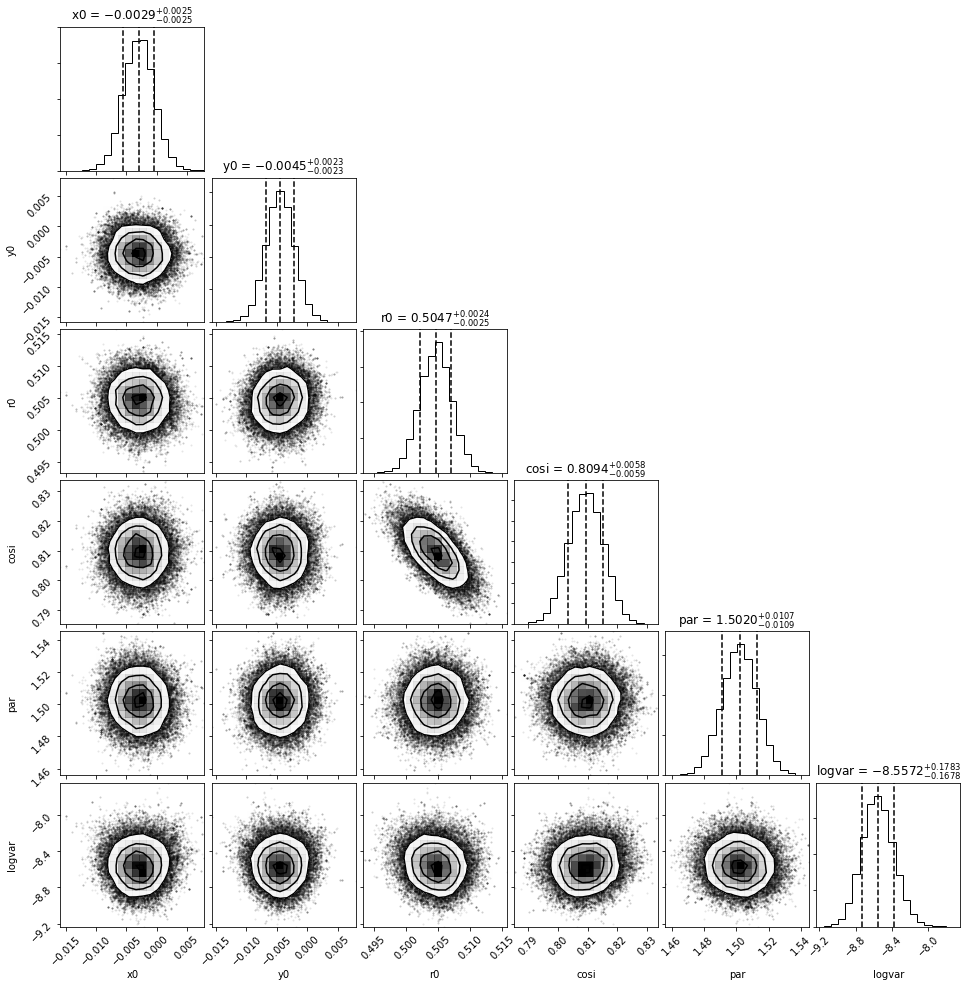

The x offset is delta_x = -2.94e-03 arcsec (+2.5e-03, -2.5e-03)
The y offset is delta_y = -4.48e-03 arcsec (+2.3e-03, -2.3e-03)
The median semi-major axis is r = 0.5047 arcsec (+0.0024, -0.0025) 
or 61.07 AU (+0.28, -0.28)
The incl is i = 35.96 deg (+0.57, -0.57)
The median position angle is PA = 86.06 deg (+0.62, -0.62)
The median log-variance in the pixel offsets from the true ellipse is -8.557e+00


In [11]:
plot_corner(sampler3, 1000, 1)
sampler_results(sampler3, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.998e-03 arcsec, delta_y = -2.321e-03 arcsec
The MLE semi-major axis is r = 0.314 arcsec
The MLE inclination is i = 31.787 degrees
The MLE position angle is PA = 82.164 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.715e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


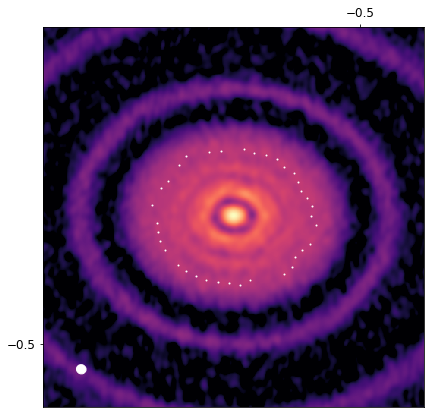

In [12]:
# Extract the ring that's at ~40 AU
xcoords4, ycoords4 = cont.extract_ring(36,44,tbins = -176+8*np.arange(45))

cont.plot_extracted_ring(cont,xcoords4, ycoords4, 0.5, 1.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_4 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     .33,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords4, ycoords4)

In [13]:
sampler4 = run_mcmc(nwalkers, nthreads, nsteps, mle_4, lnprob, xcoords4, ycoords4)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

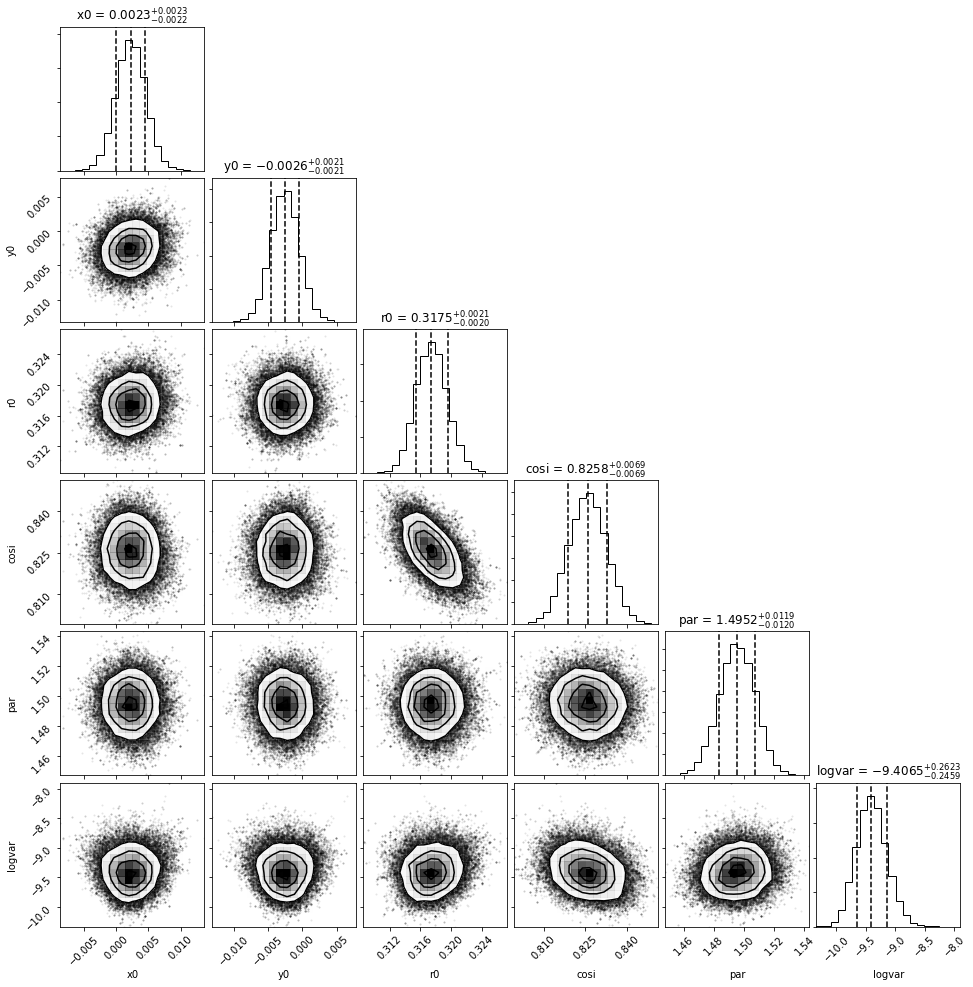

The x offset is delta_x = 2.26e-03 arcsec (+2.3e-03, -2.2e-03)
The y offset is delta_y = -2.55e-03 arcsec (+2.1e-03, -2.1e-03)
The median semi-major axis is r = 0.3175 arcsec (+0.0021, -0.0020) 
or 38.41 AU (+0.25, -0.25)
The incl is i = 34.33 deg (+0.70, -0.70)
The median position angle is PA = 85.67 deg (+0.68, -0.69)
The median log-variance in the pixel offsets from the true ellipse is -9.407e+00


In [14]:
plot_corner(sampler4, 1000, 1)
sampler_results(sampler4, 1000, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


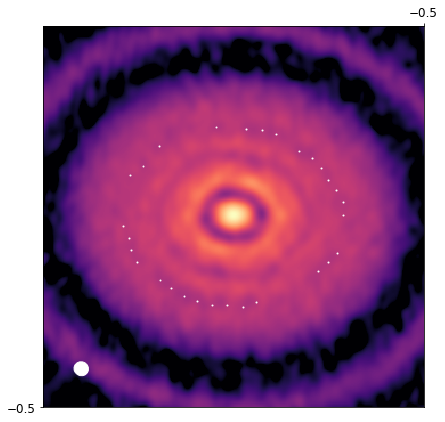

In [15]:
# Extract the gap that's at ~35 AU
xcoords5, ycoords5 = cont.extract_ring(33,37,tbins = -176+8*np.arange(45), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords5, ycoords5, 0.5, 1)

In [16]:
#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_5 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     35/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords5, ycoords5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 5.069e-03 arcsec, delta_y = -3.176e-03 arcsec
The MLE semi-major axis is r = 0.290 arcsec
The MLE inclination is i = 35.929 degrees
The MLE position angle is PA = 84.564 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.074e+01


In [17]:
sampler5 = run_mcmc(nwalkers, nthreads, nsteps, mle_5, lnprob, xcoords5, ycoords5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

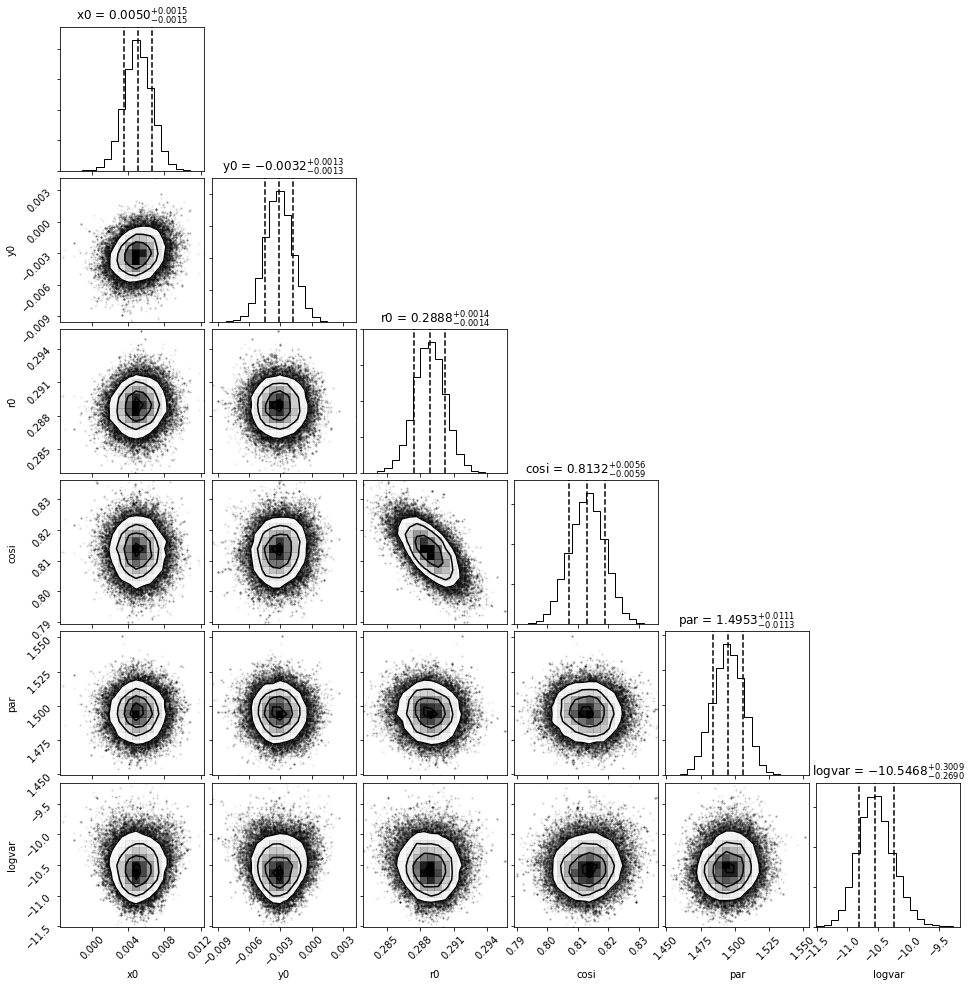

The x offset is delta_x = 5.04e-03 arcsec (+1.5e-03, -1.5e-03)
The y offset is delta_y = -3.15e-03 arcsec (+1.3e-03, -1.3e-03)
The median semi-major axis is r = 0.2888 arcsec (+0.0014, -0.0014) 
or 34.95 AU (+0.16, -0.16)
The incl is i = 35.59 deg (+0.58, -0.56)
The median position angle is PA = 85.67 deg (+0.64, -0.65)
The median log-variance in the pixel offsets from the true ellipse is -1.055e+01


In [18]:
plot_corner(sampler5, 1000, 1)
sampler_results(sampler5, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 5.178e-03 arcsec, delta_y = -4.763e-03 arcsec
The MLE semi-major axis is r = 0.228 arcsec
The MLE inclination is i = 33.901 degrees
The MLE position angle is PA = 90.227 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.638e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


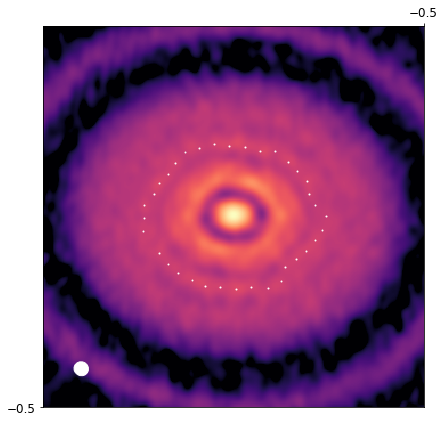

In [20]:
# Extract the gap that's at ~27 AU
xcoords6, ycoords6 = cont.extract_ring(24,30,tbins = -175+10*np.arange(36))

cont.plot_extracted_ring(cont,xcoords6, ycoords6, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_6 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     27/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords6, ycoords6)

In [21]:
sampler6 = run_mcmc(nwalkers, nthreads, nsteps, mle_6, lnprob, xcoords6, ycoords6)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

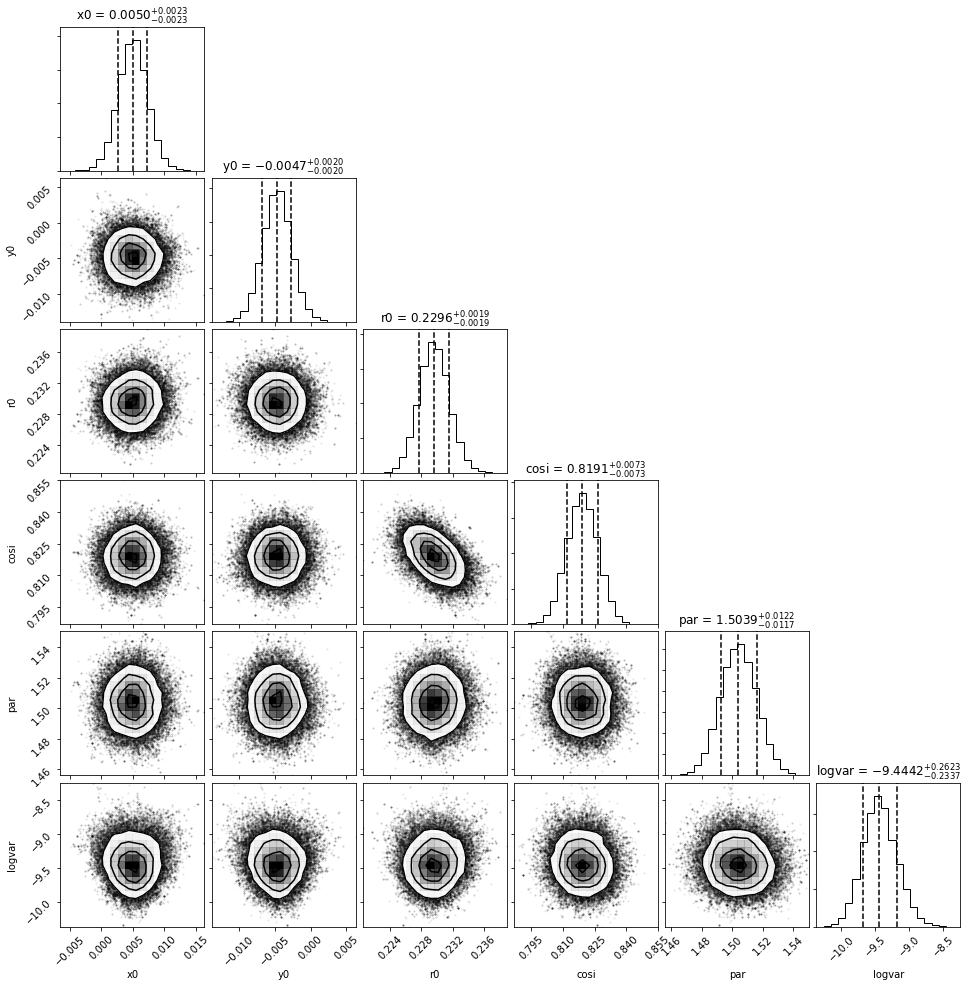

The x offset is delta_x = 4.99e-03 arcsec (+2.3e-03, -2.3e-03)
The y offset is delta_y = -4.73e-03 arcsec (+2.0e-03, -2.0e-03)
The median semi-major axis is r = 0.2296 arcsec (+0.0019, -0.0019) 
or 27.78 AU (+0.24, -0.25)
The incl is i = 35.00 deg (+0.72, -0.74)
The median position angle is PA = 86.17 deg (+0.70, -0.67)
The median log-variance in the pixel offsets from the true ellipse is -9.444e+00


In [22]:
plot_corner(sampler6, 1000, 1)
sampler_results(sampler6, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 2.469e-03 arcsec, delta_y = -4.245e-03 arcsec
The MLE semi-major axis is r = 0.197 arcsec
The MLE inclination is i = 35.798 degrees
The MLE position angle is PA = 85.500 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.050e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


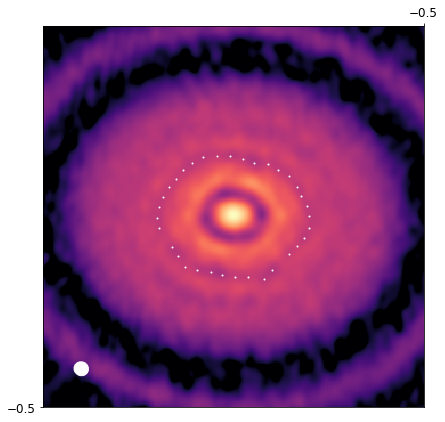

In [24]:
# Extract the gap that's at ~23 AU
xcoords7, ycoords7 = cont.extract_ring(20,26,tbins = -175+10*np.arange(36), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords7, ycoords7, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_7 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     23/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords7, ycoords7)

In [25]:
sampler7 = run_mcmc(nwalkers, nthreads, nsteps, mle_7, lnprob, xcoords7, ycoords7)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

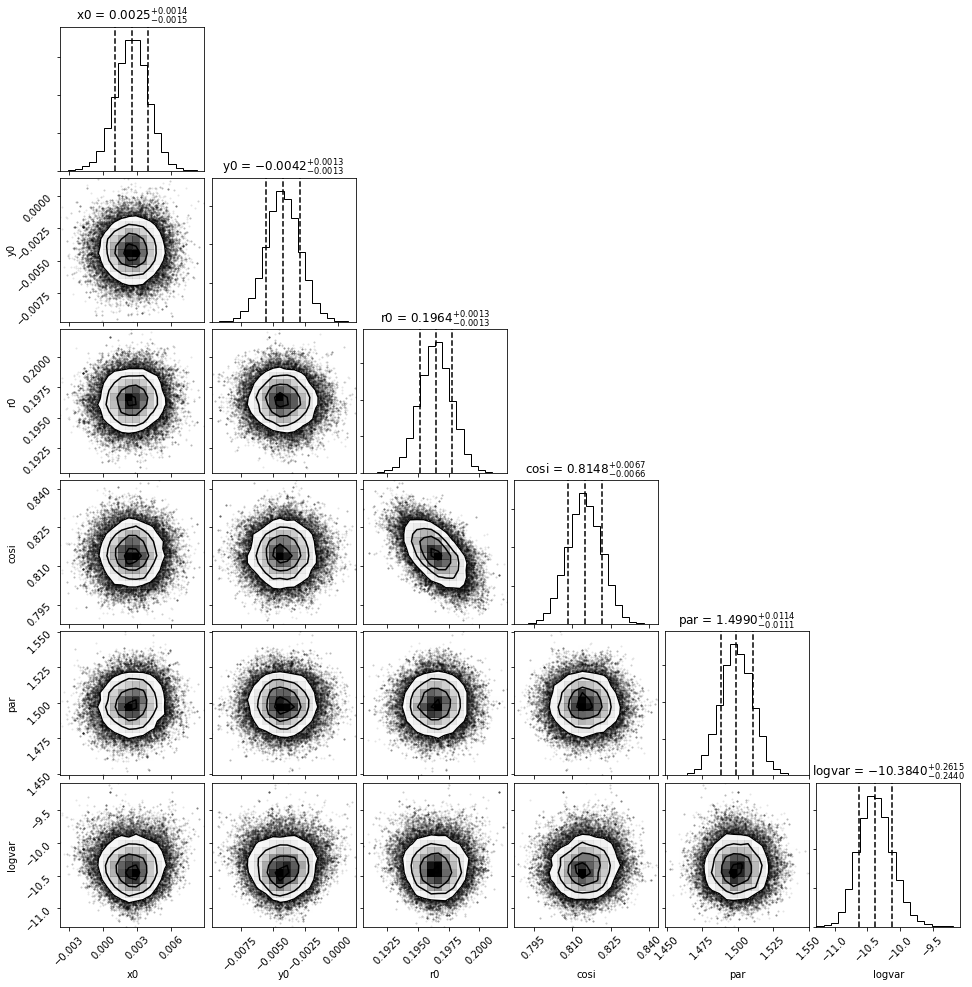

The x offset is delta_x = 2.54e-03 arcsec (+1.4e-03, -1.5e-03)
The y offset is delta_y = -4.24e-03 arcsec (+1.3e-03, -1.3e-03)
The median semi-major axis is r = 0.1964 arcsec (+0.0013, -0.0013) 
or 23.77 AU (+0.16, -0.15)
The incl is i = 35.43 deg (+0.65, -0.67)
The median position angle is PA = 85.89 deg (+0.65, -0.63)
The median log-variance in the pixel offsets from the true ellipse is -1.038e+01


In [26]:
plot_corner(sampler7, 1000, 1)
sampler_results(sampler7, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.883e-03 arcsec, delta_y = -4.037e-03 arcsec
The MLE semi-major axis is r = 0.118 arcsec
The MLE inclination is i = 34.123 degrees
The MLE position angle is PA = 80.842 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.152e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


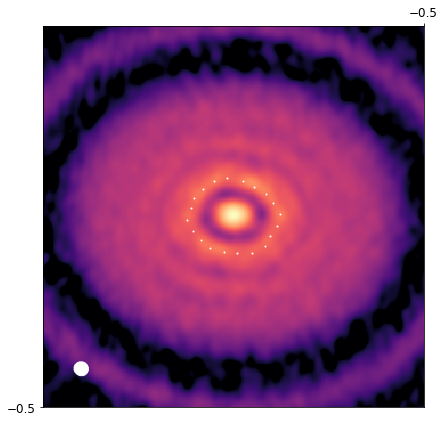

In [27]:
# Extract the ring that's at ~14 AU
xcoords8, ycoords8 = cont.extract_ring(10,20,tbins = -171+18*np.arange(20), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords8, ycoords8, 0.5, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_8 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     14/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords8, ycoords8)

In [28]:
sampler8 = run_mcmc(nwalkers, nthreads, nsteps, mle_8, lnprob, xcoords8, ycoords8)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

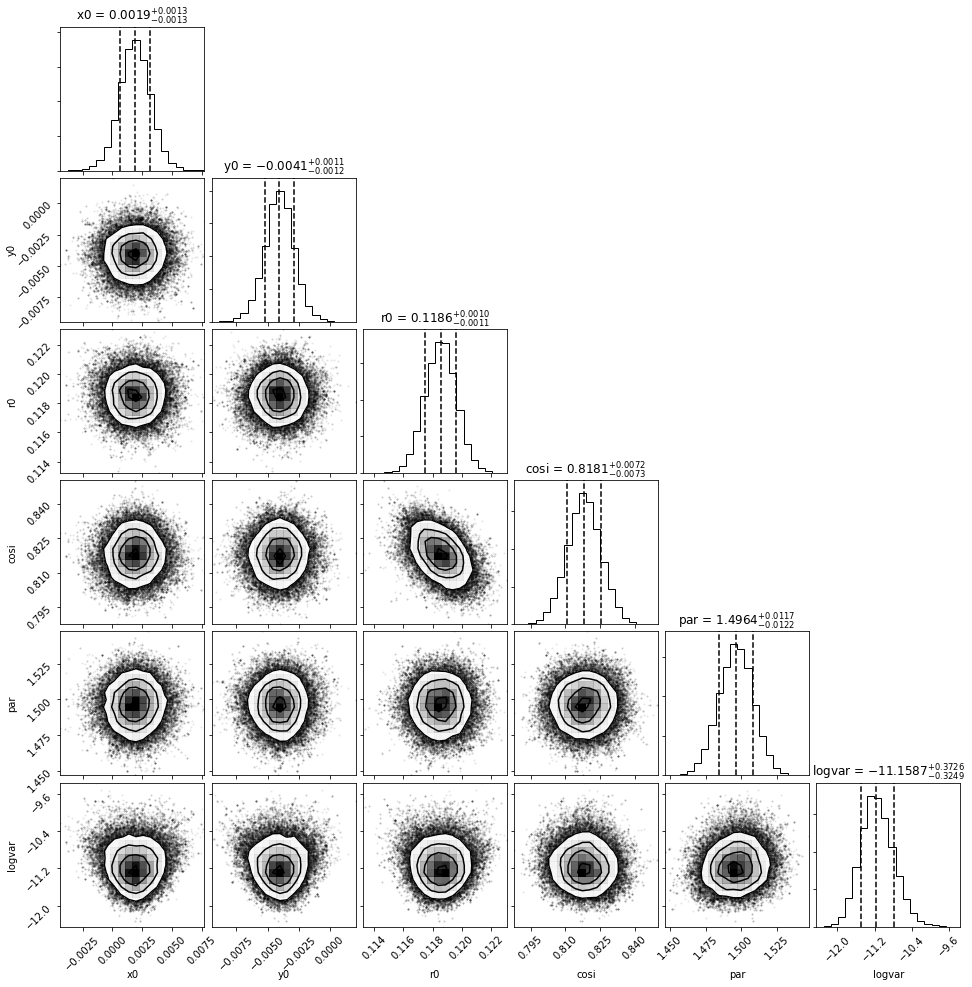

The x offset is delta_x = 1.88e-03 arcsec (+1.3e-03, -1.3e-03)
The y offset is delta_y = -4.06e-03 arcsec (+1.1e-03, -1.2e-03)
The median semi-major axis is r = 0.1186 arcsec (+0.0010, -0.0011) 
or 14.35 AU (+0.14, -0.14)
The incl is i = 35.10 deg (+0.72, -0.72)
The median position angle is PA = 85.73 deg (+0.67, -0.70)
The median log-variance in the pixel offsets from the true ellipse is -1.116e+01


In [29]:
plot_corner(sampler8, 1000, 1)
sampler_results(sampler8, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 6.962e-03 arcsec, delta_y = -3.426e-03 arcsec
The MLE semi-major axis is r = 0.813 arcsec
The MLE inclination is i = 33.063 degrees
The MLE position angle is PA = 85.842 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.039e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


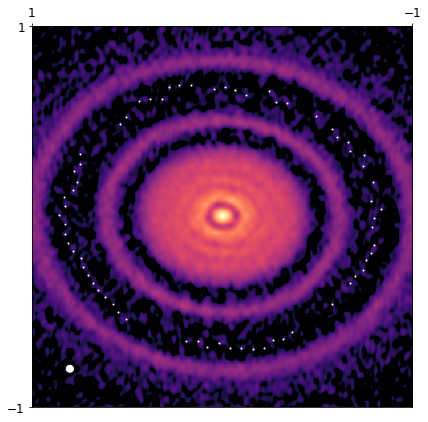

In [30]:
# Extract the ring that's at ~100 AU
xcoords9, ycoords9 = cont.extract_ring(95,105,tbins = -178+4*np.arange(90), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords9, ycoords9, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_9 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     100/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords9, ycoords9)

In [31]:
sampler9 = run_mcmc(nwalkers, nthreads, nsteps, mle_9, lnprob, xcoords9, ycoords9)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

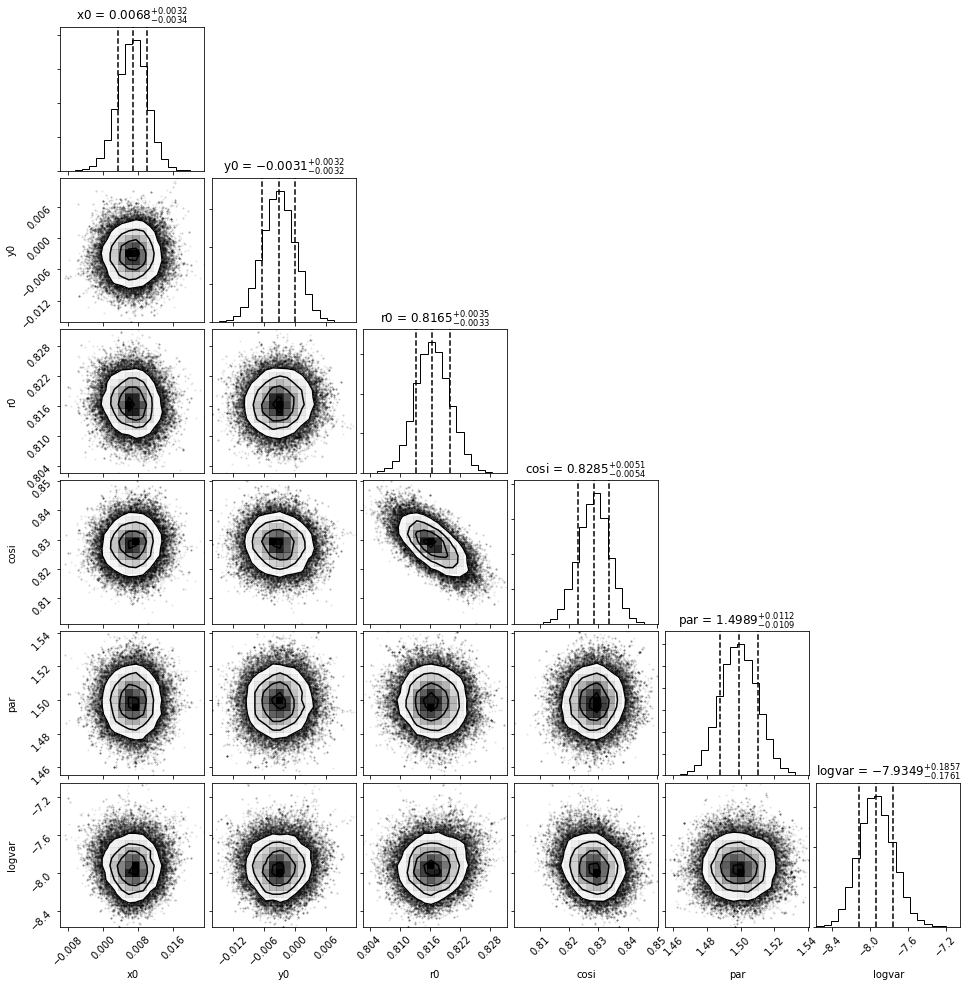

The x offset is delta_x = 6.75e-03 arcsec (+3.2e-03, -3.4e-03)
The y offset is delta_y = -3.15e-03 arcsec (+3.2e-03, -3.2e-03)
The median semi-major axis is r = 0.8165 arcsec (+0.0035, -0.0033) 
or 98.80 AU (+0.39, -0.39)
The incl is i = 34.06 deg (+0.55, -0.53)
The median position angle is PA = 85.88 deg (+0.64, -0.62)
The median log-variance in the pixel offsets from the true ellipse is -7.935e+00


In [32]:
plot_corner(sampler9, 1000, 1)
sampler_results(sampler9, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -3.813e-03 arcsec, delta_y = -1.458e-03 arcsec
The MLE semi-major axis is r = 0.866 arcsec
The MLE inclination is i = 33.650 degrees
The MLE position angle is PA = 86.020 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.114e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


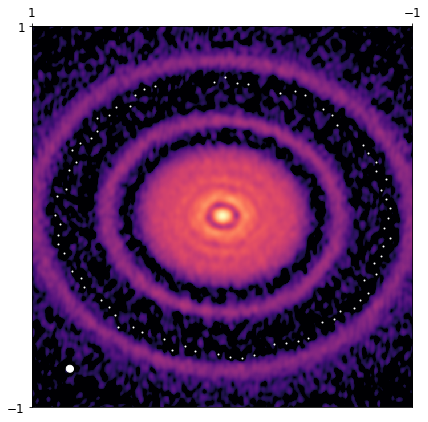

In [33]:
# Extract the gap that's at ~105 AU
xcoords10, ycoords10 = cont.extract_ring(100,110,tbins = -178+4*np.arange(90), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords10, ycoords10, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_10 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     105/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords10, ycoords10)

In [34]:
sampler10 = run_mcmc(nwalkers, nthreads, nsteps, mle_10, lnprob, xcoords10, ycoords10)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

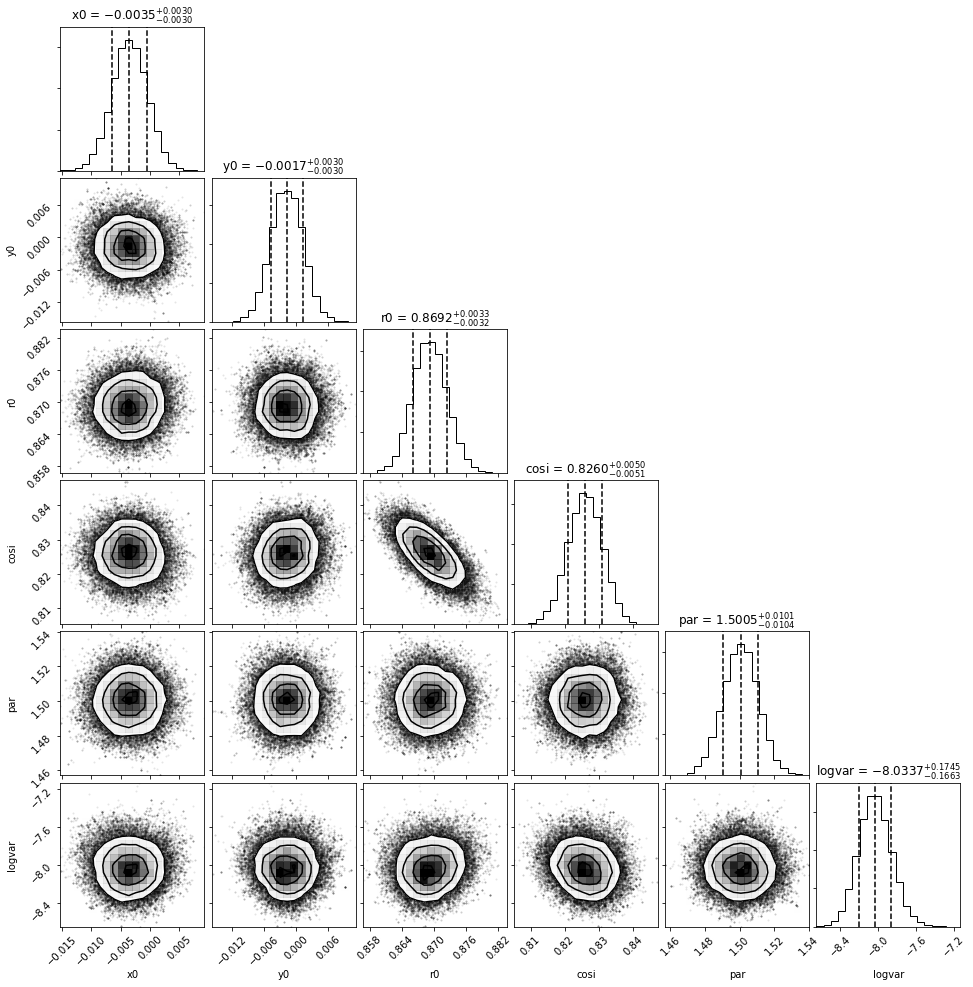

The x offset is delta_x = -3.50e-03 arcsec (+3.0e-03, -3.0e-03)
The y offset is delta_y = -1.71e-03 arcsec (+3.0e-03, -3.0e-03)
The median semi-major axis is r = 0.8692 arcsec (+0.0033, -0.0032) 
or 105.18 AU (+0.36, -0.36)
The incl is i = 34.31 deg (+0.51, -0.51)
The median position angle is PA = 85.97 deg (+0.58, -0.60)
The median log-variance in the pixel offsets from the true ellipse is -8.034e+00


In [35]:
plot_corner(sampler10, 1000, 1)
sampler_results(sampler10, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.516e-03 arcsec, delta_y = -6.800e-03 arcsec
The MLE semi-major axis is r = 0.741 arcsec
The MLE inclination is i = 33.727 degrees
The MLE position angle is PA = 86.886 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.363e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


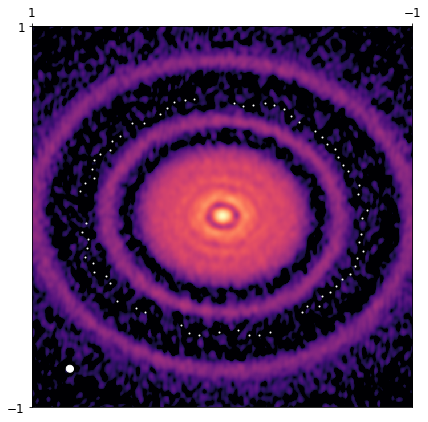

In [36]:
# Extract the gap that's at ~90 AU
xcoords11, ycoords11 = cont.extract_ring(85,95,tbins = -178+4*np.arange(90), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords11, ycoords11, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_11 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     95/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords11, ycoords11)

In [37]:
sampler11 = run_mcmc(nwalkers, nthreads, nsteps, mle_11, lnprob, xcoords11, ycoords11)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

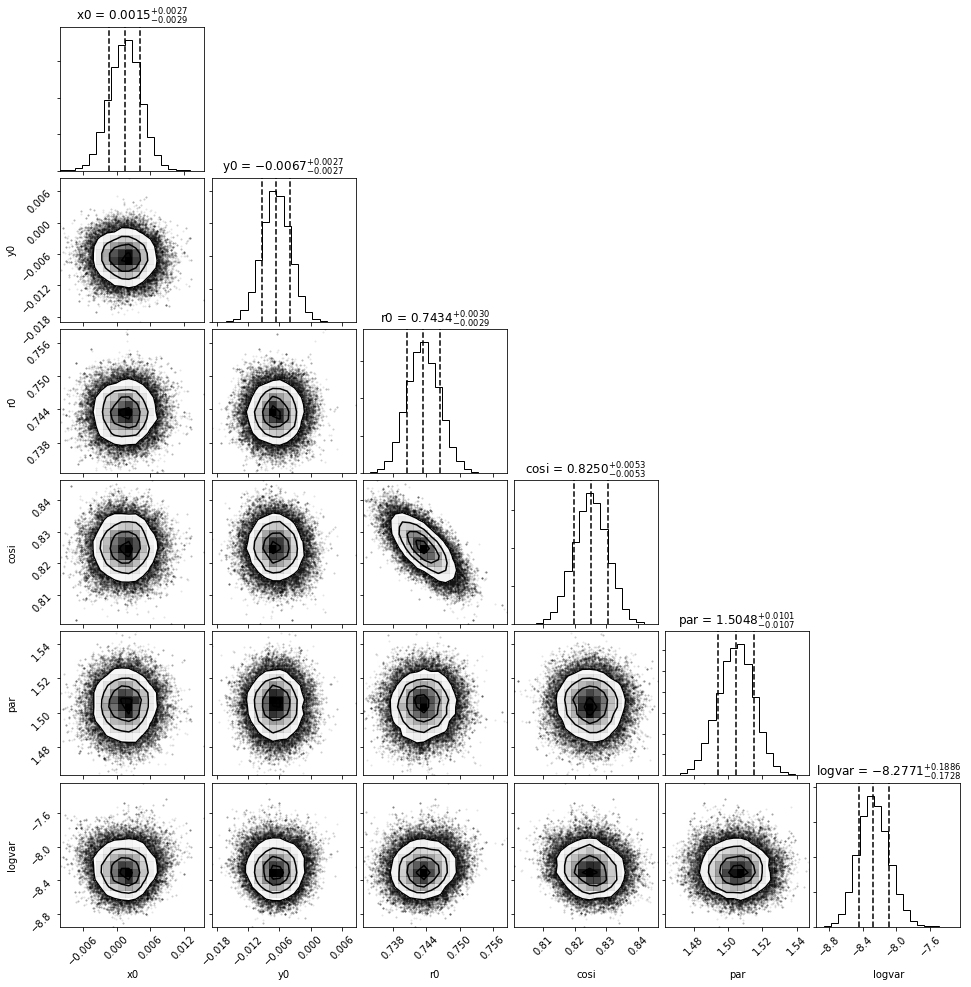

The x offset is delta_x = 1.51e-03 arcsec (+2.7e-03, -2.9e-03)
The y offset is delta_y = -6.68e-03 arcsec (+2.7e-03, -2.7e-03)
The median semi-major axis is r = 0.7434 arcsec (+0.0030, -0.0029) 
or 89.95 AU (+0.33, -0.33)
The incl is i = 34.41 deg (+0.54, -0.54)
The median position angle is PA = 86.22 deg (+0.58, -0.61)
The median log-variance in the pixel offsets from the true ellipse is -8.277e+00


In [38]:
plot_corner(sampler11, 1000, 1)
sampler_results(sampler11, 1000, cont.src_distance)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 3.085e-03 arcsec, delta_y = -3.941e-03 arcsec
The MLE semi-major axis is r = 0.073 arcsec
The MLE inclination is i = 38.341 degrees
The MLE position angle is PA = 78.422 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.480e+01


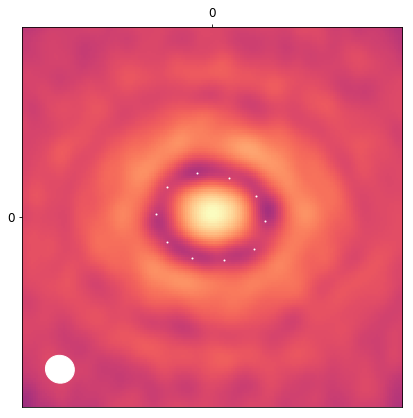

In [5]:
# Extract the gap that's at ~10 AU
xcoords12, ycoords12 = cont.extract_ring(5,15,tbins = -162+36*np.arange(10), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords12, ycoords12, 0.4, 0.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_12 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     10/120.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords12, ycoords12)

In [6]:
sampler12 = run_mcmc(nwalkers, nthreads, 3000, mle_12, lnprob, xcoords12, ycoords12)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

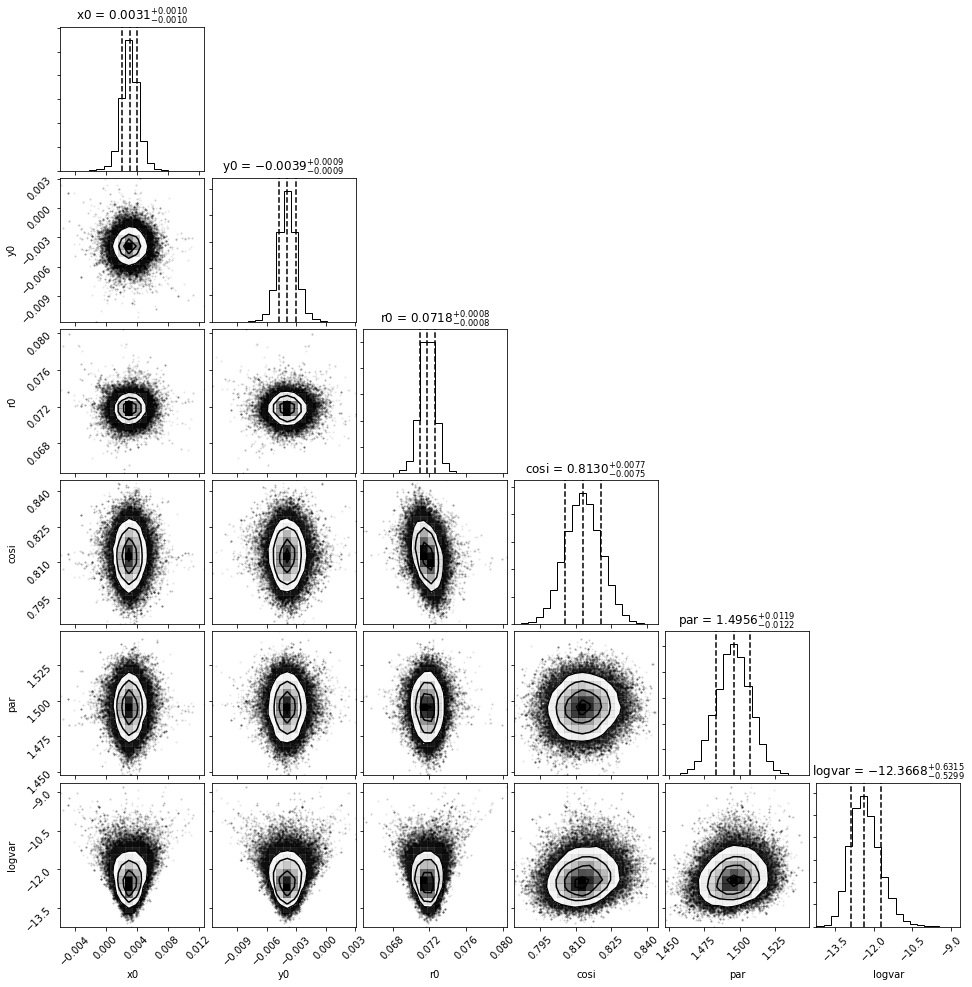

The x offset is delta_x = 3.09e-03 arcsec (+1.0e-03, -9.8e-04)
The y offset is delta_y = -3.90e-03 arcsec (+9.0e-04, -8.7e-04)
The median semi-major axis is r = 0.0718 arcsec (+0.0008, -0.0008) 
or 8.69 AU (+0.11, -0.11)
The incl is i = 35.61 deg (+0.74, -0.76)
The median position angle is PA = 85.69 deg (+0.68, -0.70)
The median log-variance in the pixel offsets from the true ellipse is -1.237e+01


In [7]:
plot_corner(sampler12, 1500, 1)
sampler_results(sampler12, 1500, cont.src_distance)

In [9]:

maxrad = 150
radialbins = 0.5+np.arange(0, maxrad)

newcont = Continuum(disk['filename'], 1.7e-3,-3.1e-3, 85.8, 34.9,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))





max [14, 27, 38, 74, 97, 120, 141]
min [8, 23, 35, 60, 89, 105, 137]


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


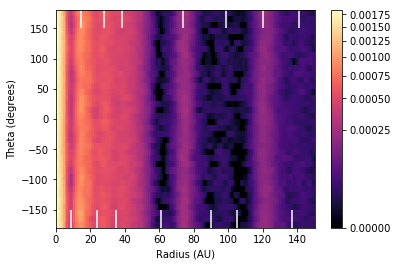

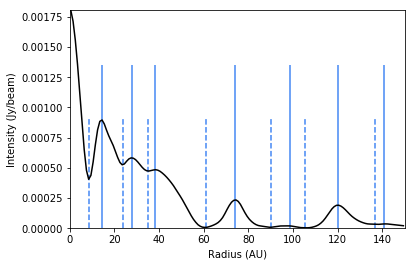

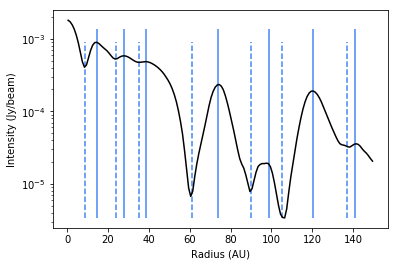

(0, 150)

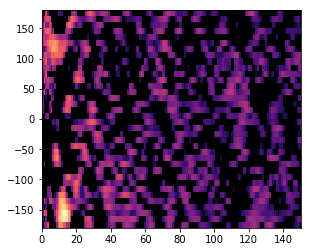

In [11]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
gaps = [8.7, 23.8, 35.0, 61, 90.0, 105.2,137]
rings = [14.4, 27.8,38.4, 74, 98.8, 120.3,141]
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = 150)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)